# DATA608 - Story 5 : What Is The Effect Of The Earth's Temperature on Cyclonic Storms?


Historic data indicates that the occurrence and intensity of cyclonic storms (Hurricanes, Typhoons and Tornados) increases with the increased earth temperature. For this assignment you will need to tell this story to a non-technical audience (eg: a high-school earth science class).

Notes:
- Source historic data for a period of at least 25 years on a measure of the earth's temperature.
- Source data on the occurrence and intensity of hurricanes, typhoons and tornados for the same historic period.
- Perform the data analysis to establish the correlations between earth temperature and storm occurrence and intensity.
- Tell the story of this data and your analysis using data visualizations and other illustrations (eg: pictures of storm damage) in a presentation that will be accessible to a high-school earth science class.

# Background

Taken from: https://hurricanescience.org/society/impacts/tornadoes/
# 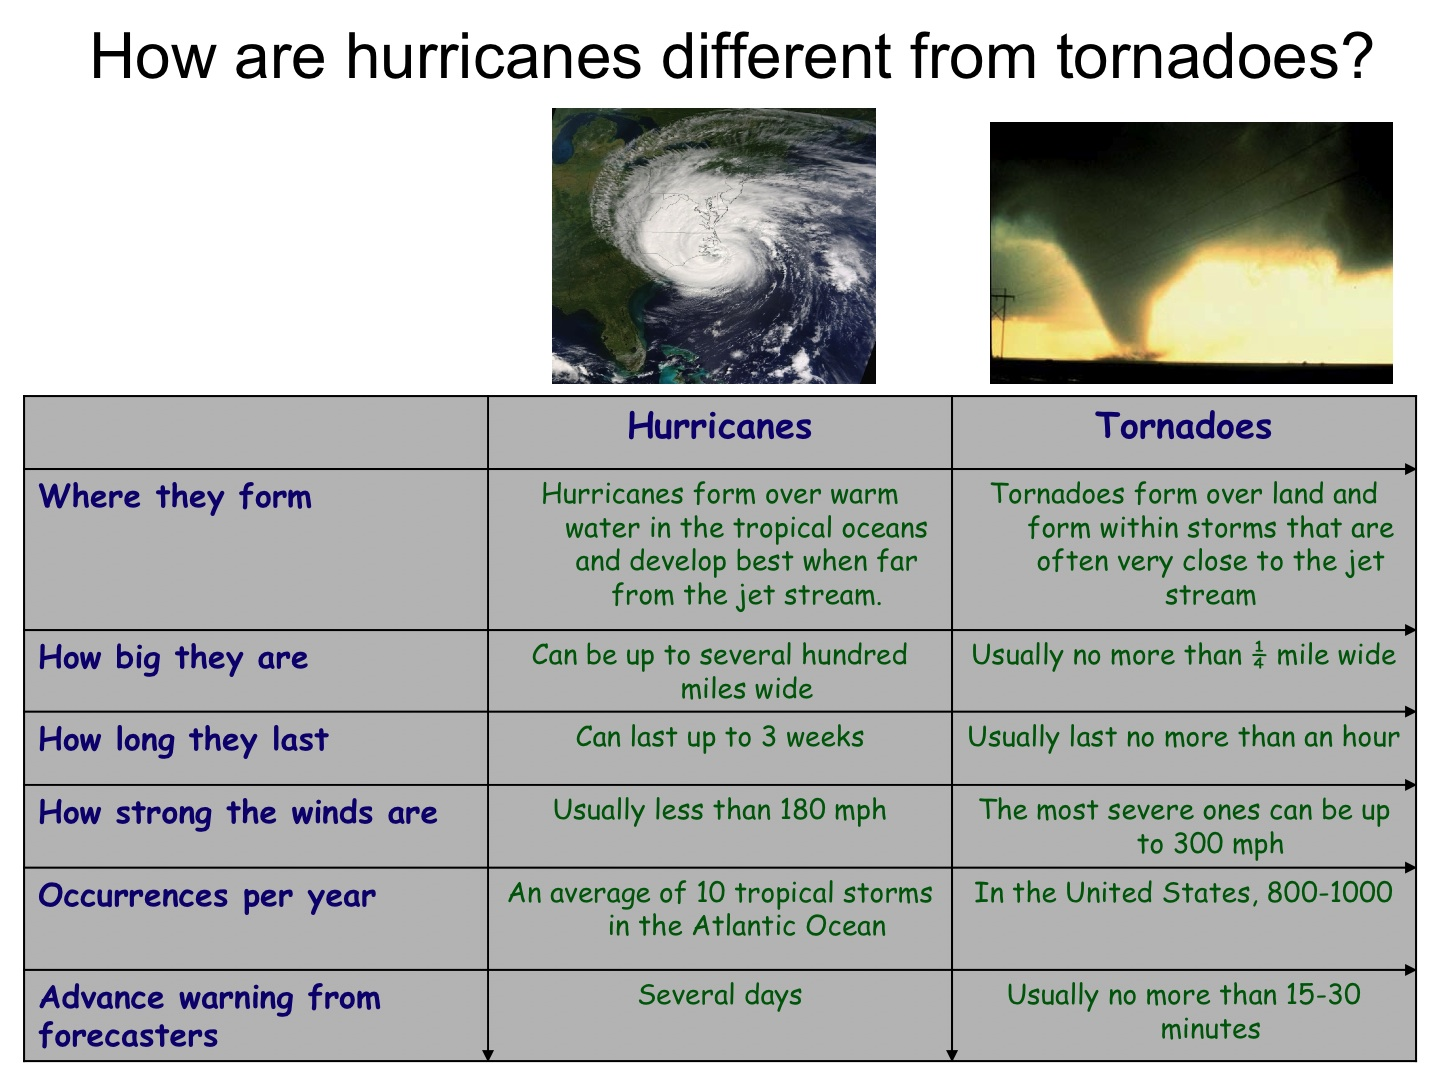


As based on the definitions by dictionary.com, 'hurricane' is used to describe tropical cyclones from the Atlantic Ocean, Caribbean Sea, Gulf of Mexico, and the central northern and eastern Pacific Ocean, whereas 'typhoon' is used for tropical cyclones from the western and northwestern Pacific Ocean and the northern Indian Ocean.




# Installing Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

I first started by importing packages which I would need to perform statistical analysis and make visualizations.

# Loading Datasets

## Weather Anomaly Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/rkasa01/DATA608_Story5/main/data.csv'

globalweatherdata = pd.read_csv(url,skiprows=4)
print(globalweatherdata.head())

   Year  Anomaly
0  1999     0.62
1  2000     0.40
2  2001     0.42
3  2002     0.57
4  2003     0.62


I first started with a weather anomaly dataset. These anomalies are tracked with respect to the 1901-2000 average global weather. By tracking the deviation from the prrevious century, we can see how much the average global weather has changed across time, and by how much it increases every year.

## Cyclonic Storm Dataset

In [ ]:
import requests
url2 = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-atl-02052024.txt'
response = requests.get(url2)

hurricane_data = []

for line in response.iter_lines():
    line = line.decode('utf-8')  # Decode bytes to string
    if line.strip():  # Skip empty lines
        if line.startswith('AL'):  # Identify hurricane data lines
            hurricane_info = line.split(',')
            hurricane_data.append(hurricane_info)

hurricane_df = pd.DataFrame(hurricane_data)
print(hurricane_df.head())



          0                    1        2 3
0  AL011851              UNNAMED       14  
1  AL021851              UNNAMED        1  
2  AL031851              UNNAMED        1  
3  AL041851              UNNAMED       49  
4  AL051851              UNNAMED       16  


In [ ]:
import requests
url2 = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-atl-02052024.txt'
response = requests.get(url2)

hurricane_data = []
current_hurricane = []

if response.status_code == 200:
    for line in response.iter_lines():
        line = line.decode('utf-8')  # Decode bytes to string
        if line.strip():  # Skip empty lines
            if line.startswith(('AL', 'EP', 'CP', 'NA', 'SA')):
                # Start of a new hurricane
                if current_hurricane:
                    hurricane_data.append(current_hurricane)
                    current_hurricane = []
                current_hurricane.append(line.split(','))
            else:
                # Continuation of the current hurricane
                current_hurricane.append(line.split(','))
    hurricane_data.append(current_hurricane)
    hurricane_df = pd.DataFrame(sum(hurricane_data, []))

    print(hurricane_df.head())

         0                    1        2    3       4        5     6      7   \
0  AL011851              UNNAMED       14         None     None  None   None   
1  18510625                 0000            HU   28.0N    94.8W    80   -999   
2  18510625                 0600            HU   28.0N    95.4W    80   -999   
3  18510625                 1200            HU   28.0N    96.0W    80   -999   
4  18510625                 1800            HU   28.1N    96.5W    80   -999   

      8      9   ...     11     12     13     14     15     16     17     18  \
0   None   None  ...   None   None   None   None   None   None   None   None   
1   -999   -999  ...   -999   -999   -999   -999   -999   -999   -999   -999   
2   -999   -999  ...   -999   -999   -999   -999   -999   -999   -999   -999   
3   -999   -999  ...   -999   -999   -999   -999   -999   -999   -999   -999   
4   -999   -999  ...   -999   -999   -999   -999   -999   -999   -999   -999   

      19     20  
0   None   None  
1 

The cyclonic dataset presented several challenges in terms of extracting the information. The format was not the most straightforward to work with but I carefully followed explanations detailed in its respective pdf file (https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-nencpac-1949-2021.pdf) which helped with sorting out the numbers. In the txt format, there was a row for each hurricane which contained its name, basin, yearly cyclone number and the year. Following that row were several rows which contained information such as the maximum wind that was reached in different areas. Because of this, different storms had a different number of rows assigned which followed it.

Here, we have so far extracted the header lines pertaining to each hurricane, and then all the data in each cyclone's subset. In the next steps, I will attempt to extract more information from it.

# Data Wrangling

## Converting Weather Anolmaly to Farenheit

In [ ]:
globalweatherdata['Temperature'] = (globalweatherdata['Anomaly'] * 9/5) + 32
print(globalweatherdata.head())

   Year  Anomaly  Temperature
0  1999     0.62       33.116
1  2000     0.40       32.720
2  2001     0.42       32.756
3  2002     0.57       33.026
4  2003     0.62       33.116


## Extracting Cyclonic Dataset

In [ ]:
import requests
url2 = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-atl-02052024.txt'
response = requests.get(url2)

hurricane_data = []

if response.status_code == 200:
    for line in response.iter_lines():
        line = line.decode('utf-8')  # Decode bytes to string
        if line.strip():  # Skip empty lines
            if line.startswith(('AL', 'EP', 'CP', 'NA', 'SA')):
                basin = line[:2]  # Extract Basin
                name = line[9:30].strip()  # Extract Name
                yearly_cyclone_number = line[2:4]  # Extract Yearly Cyclone Number
                year = line[4:8]  # Extract Year
            else:
                # Continuation of the current hurricane
                hurricane_info = line.split(',')
                date = hurricane_info[0].strip()
                time = hurricane_info[1].strip()
                max_wind = hurricane_info[6].strip()
                if max_wind == 'HU':
                    max_wind = np.nan  # Convert 'HU' to NaN
                hurricane_data.append([basin, name, yearly_cyclone_number, year, date, time, max_wind])

    hurricane_df = pd.DataFrame(hurricane_data)
    hurricane_df.columns = ['Basin', 'Name', 'Yearly Cyclone Number', 'Year', 'Date', 'Time', 'Max Wind']

    hurricane_df['Max Wind'] = pd.to_numeric(hurricane_df['Max Wind'], errors='coerce')

    last_25_years_df = hurricane_df[hurricane_df['Year'].astype(int) >= 1997]

    print(last_25_years_df.head())

      Basin      Name Yearly Cyclone Number  Year      Date  Time  Max Wind
40569    AL  UNNAMED,                    01  1997  19970531  1800        25
40570    AL  UNNAMED,                    01  1997  19970601  0000        25
40571    AL  UNNAMED,                    01  1997  19970601  0600        30
40572    AL  UNNAMED,                    01  1997  19970601  1200        35
40573    AL  UNNAMED,                    01  1997  19970601  1800        45


Here, we have prepared a dataframe with each unique hurricane's name and respective information. I have limited the data to the last 25 years that both datasets have in common: 1997-2022. I decided to work with maximum sustain wind recorded, or 'max_wind', as this is the measure I will use for intensity. Maximum sustained wind is the highest wind speed which has been sustained for at least one minute. It is recorded in knots, or nautical miles per hour.

# Summary Statistics
## Weather Anomalies

In [ ]:
summary_stats_weather=globalweatherdata.describe()
print(summary_stats_weather)

              Year    Anomaly  Temperature
count    26.000000  26.000000    26.000000
mean   2011.500000   0.738077    33.328538
std       7.648529   0.197140     0.354852
min    1999.000000   0.400000    32.720000
25%    2005.250000   0.612500    33.102500
50%    2011.500000   0.680000    33.224000
75%    2017.750000   0.885000    33.593000
max    2024.000000   1.220000    34.196000


## Cyclonic Data - Maximum Wind (knots)

In [ ]:
summary_stats = last_25_years_df.describe()
print(summary_stats)

           Max Wind
count  13407.000000
mean      49.787424
std       25.489164
min       10.000000
25%       30.000000
50%       45.000000
75%       60.000000
max      160.000000


# Data Visualizations


## Weather

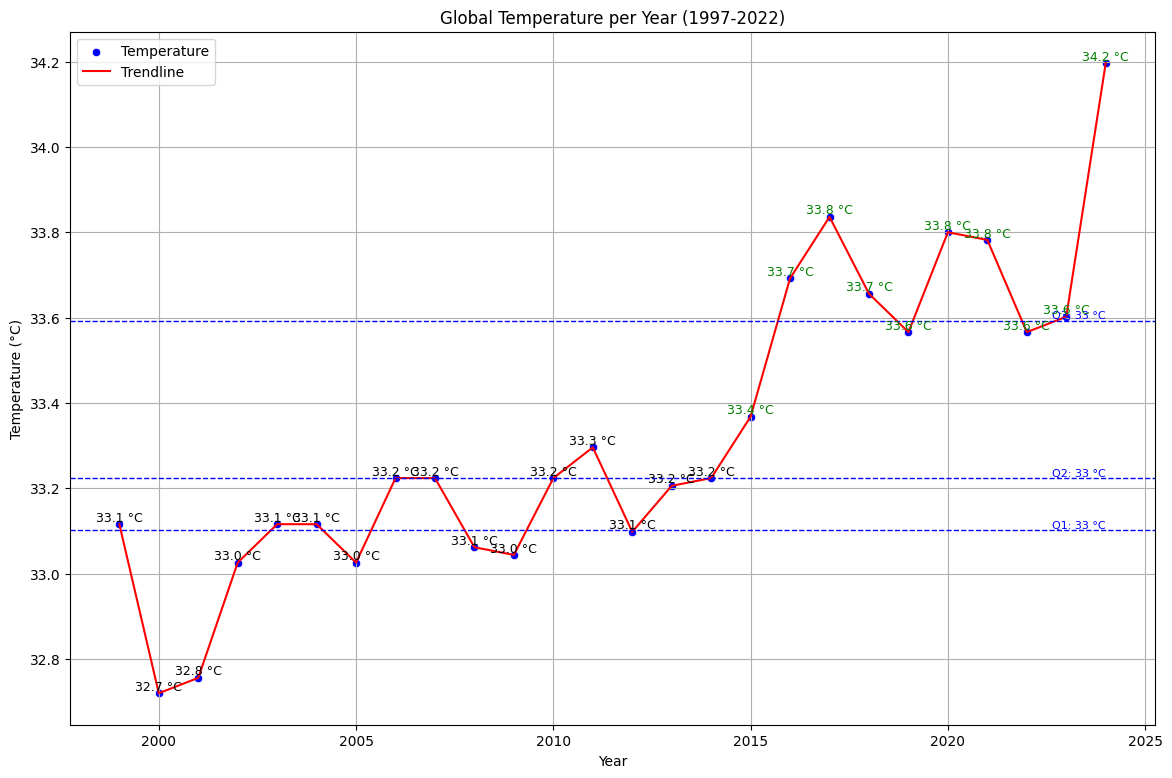

In [ ]:
quartiles = globalweatherdata['Temperature'].quantile([0.25, 0.5, 0.75])

plt.figure(figsize=(14, 9))
sns.scatterplot(data=globalweatherdata, x='Year', y='Temperature', color='blue', label='Temperature')
sns.lineplot(data=globalweatherdata, x='Year', y='Temperature', color='red', label='Trendline')

for q in quartiles:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles):
    plt.text(globalweatherdata['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)} °C', color='blue', ha='right', va='bottom', fontsize=8)
average_temperature = globalweatherdata['Temperature'].mean()

for _, row in globalweatherdata.iterrows():
    if row['Temperature'] > average_temperature:
        plt.text(row['Year'], row['Temperature'], f"{row['Temperature']:.1f} °C", color='green', ha='center', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Temperature'], f"{row['Temperature']:.1f} °C", color='black', ha='center', va='bottom', fontsize=9)

plt.title('Global Temperature per Year (1997-2022)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()

## Frequency of Cyclonic Storms Yearly

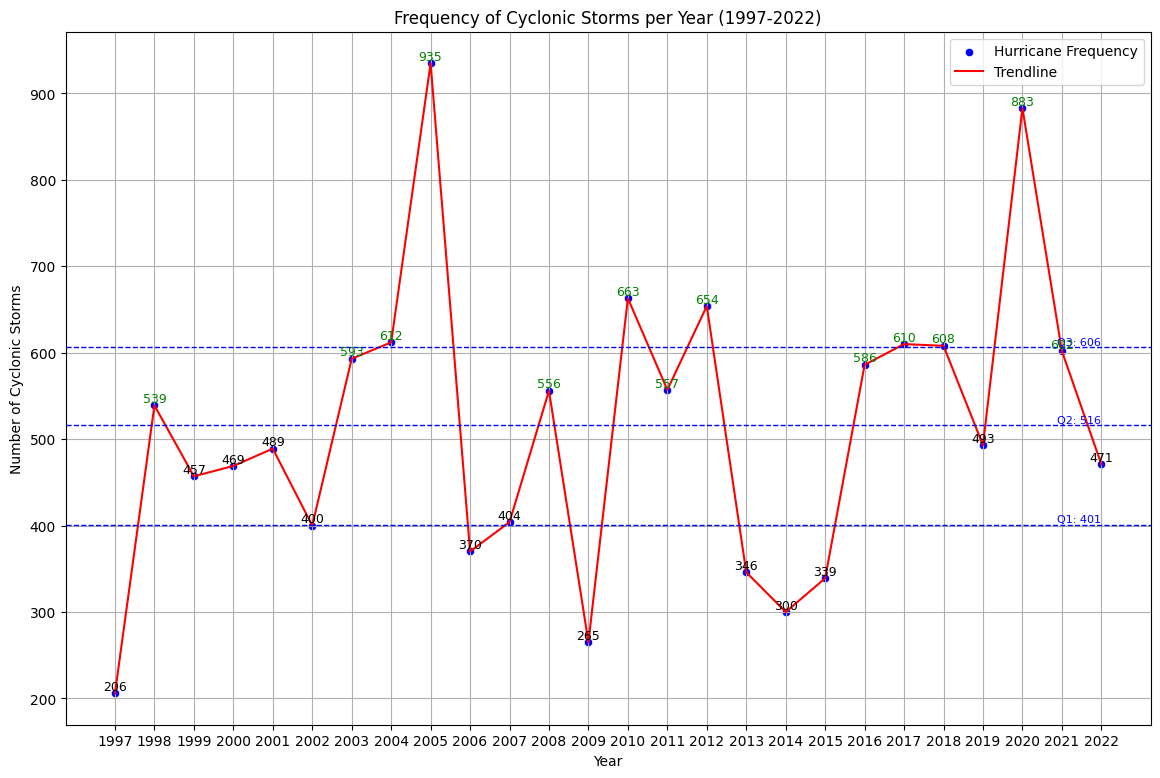

In [54]:
hurricanes_per_year_df = hurricane_df.groupby('Year').size().reset_index(name='Hurricane Frequency')
hurricanes_per_year_df = hurricanes_per_year_df[(hurricanes_per_year_df['Year'] >= '1997') & (hurricanes_per_year_df['Year'] <= '2022')]


quartiles = hurricanes_per_year_df['Hurricane Frequency'].quantile([0.25, 0.5, 0.75])
plt.figure(figsize=(14, 9))
sns.scatterplot(data=hurricanes_per_year_df, x='Year', y='Hurricane Frequency', color='blue', label='Hurricane Frequency')
sns.lineplot(data=hurricanes_per_year_df, x='Year', y='Hurricane Frequency', color='red', label='Trendline')

for q in quartiles:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles):
    plt.text(hurricanes_per_year_df['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)}', color='blue', ha='right', va='bottom', fontsize=8)

average_frequency = hurricanes_per_year_df['Hurricane Frequency'].mean()
for _, row in hurricanes_per_year_df.iterrows():
    if row['Hurricane Frequency'] > average_frequency:
        plt.text(row['Year'], row['Hurricane Frequency'], str(row['Hurricane Frequency']), color='green', ha='center', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Hurricane Frequency'], str(row['Hurricane Frequency']), color='black', ha='center', va='bottom', fontsize=9)

plt.title('Frequency of Cyclonic Storms per Year (1997-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Cyclonic Storms')
plt.grid(True)
plt.legend()
plt.show()


# Maximum Sustained Wind

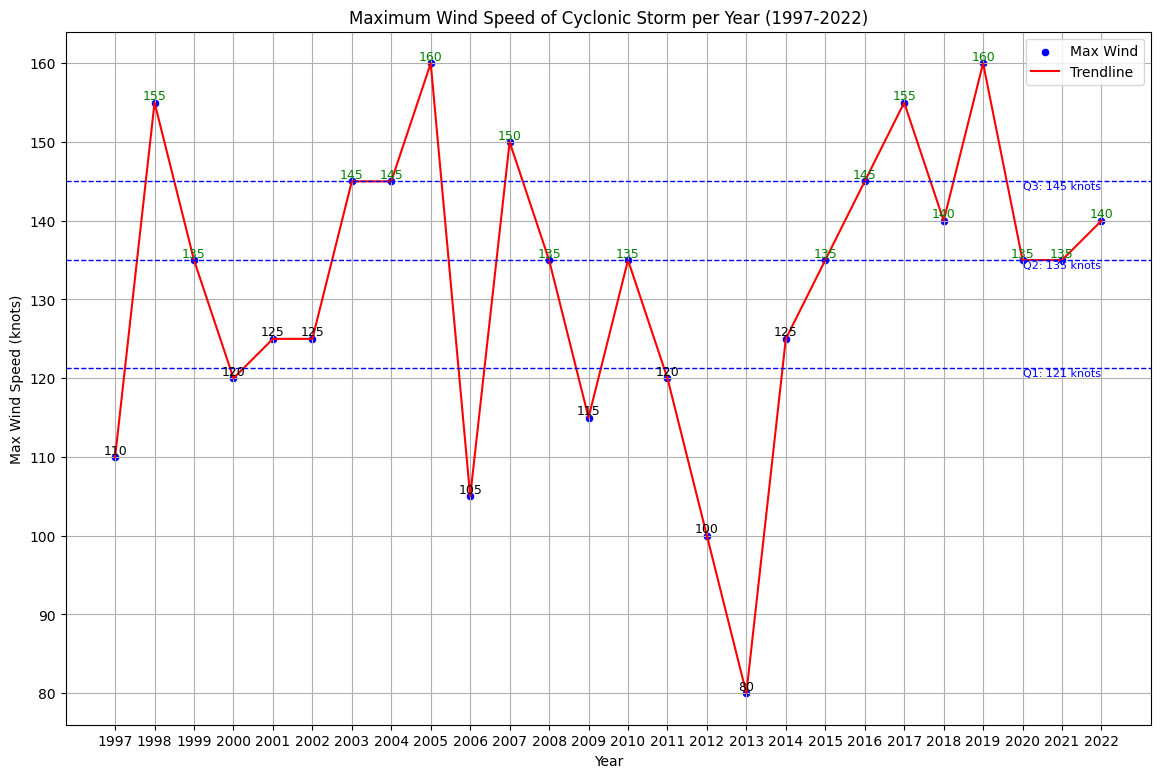

In [60]:
max_wind_per_year_df = hurricane_df.groupby('Year')['Max Wind'].max().reset_index()
max_wind_per_year_df = max_wind_per_year_df[(max_wind_per_year_df['Year'] >= '1997') & (max_wind_per_year_df['Year'] <= '2022')]

quartiles = max_wind_per_year_df['Max Wind'].quantile([0.25, 0.5, 0.75])
plt.figure(figsize=(14, 9))
sns.scatterplot(data=max_wind_per_year_df, x='Year', y='Max Wind', color='blue', label='Max Wind')
sns.lineplot(data=max_wind_per_year_df, x='Year', y='Max Wind', color='red', label='Trendline')

for q in quartiles:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles):
    plt.text(max_wind_per_year_df['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)} knots', color='blue', ha='right', va='top', fontsize=8)

average_wind_speed = max_wind_per_year_df['Max Wind'].mean()
for _, row in max_wind_per_year_df.iterrows():
    if row['Max Wind'] > average_wind_speed:
        plt.text(row['Year'], row['Max Wind'], str(row['Max Wind']), color='green', ha='center', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Max Wind'], str(row['Max Wind']), color='black', ha='center', va='bottom', fontsize=9)

plt.title('Maximum Wind Speed of Cyclonic Storm per Year (1997-2022)')
plt.xlabel('Year')
plt.ylabel('Max Wind Speed (knots)')
plt.grid(True)
plt.legend()
plt.show()

## Combined Figure

<ipython-input-89-1da9a4fae79d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_max_wind.set_xticklabels(scatter_max_wind.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees


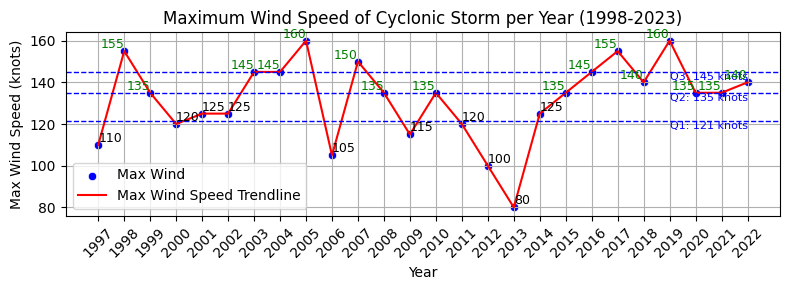

<ipython-input-89-1da9a4fae79d>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_hurricane_freq.set_xticklabels(scatter_hurricane_freq.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees


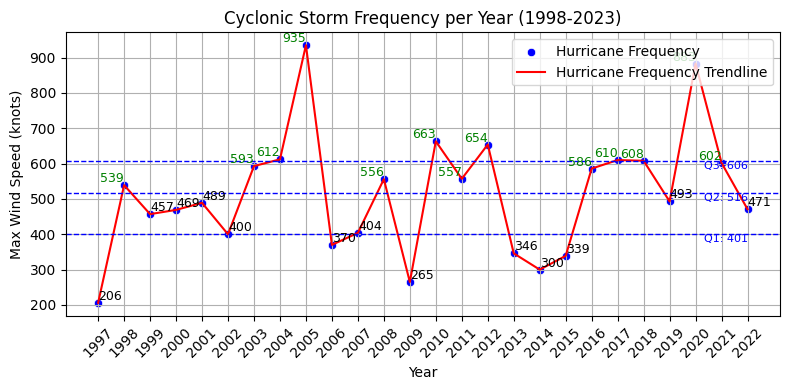

<ipython-input-89-1da9a4fae79d>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_temperature.set_xticklabels(scatter_temperature.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees


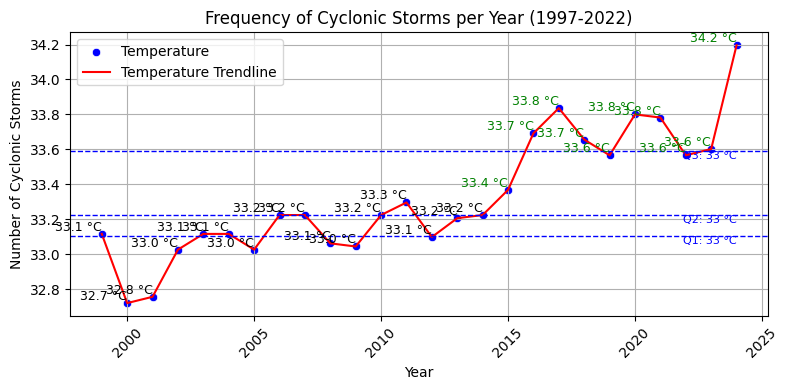

In [89]:
quartiles_max_wind = max_wind_per_year_df['Max Wind'].quantile([0.25, 0.5, 0.75])
plt.figure(figsize=(8, 3))
scatter_max_wind = sns.scatterplot(data=max_wind_per_year_df, x='Year', y='Max Wind', color='blue', label='Max Wind')
scatter_max_wind.set_xticklabels(scatter_max_wind.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees
line_max_wind = sns.lineplot(data=max_wind_per_year_df, x='Year', y='Max Wind', color='red', label='Max Wind Speed Trendline')

for q in quartiles_max_wind:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles_max_wind):
    plt.text(max_wind_per_year_df['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)} knots', color='blue', ha='right', va='top', fontsize=8)

average_wind_speed = max_wind_per_year_df['Max Wind'].mean()
for _, row in max_wind_per_year_df.iterrows():
    if row['Max Wind'] > average_wind_speed:
        plt.text(row['Year'], row['Max Wind'], str(row['Max Wind']), color='green', ha='right', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Max Wind'], str(row['Max Wind']), color='black', ha='left', va='bottom', fontsize=9)

plt.title('Maximum Wind Speed of Cyclonic Storm per Year (1998-2023)')
plt.xlabel('Year')
plt.ylabel('Max Wind Speed (knots)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



quartiles_hurricane_frequency = hurricanes_per_year_df['Hurricane Frequency'].quantile([0.25, 0.5, 0.75])
plt.figure(figsize=(8, 4))
scatter_hurricane_freq = sns.scatterplot(data=hurricanes_per_year_df, x='Year', y='Hurricane Frequency', color='blue', label='Hurricane Frequency')
scatter_hurricane_freq.set_xticklabels(scatter_hurricane_freq.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees
line_hurricane_freq = sns.lineplot(data=hurricanes_per_year_df, x='Year', y='Hurricane Frequency', color='red', label='Hurricane Frequency Trendline')

for q in quartiles_hurricane_frequency:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles_hurricane_frequency):
    plt.text(hurricanes_per_year_df['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)}', color='blue', ha='right', va='top', fontsize=8)

average_frequency = hurricanes_per_year_df['Hurricane Frequency'].mean()
for _, row in hurricanes_per_year_df.iterrows():
    if row['Hurricane Frequency'] > average_frequency:
        plt.text(row['Year'], row['Hurricane Frequency'], str(row['Hurricane Frequency']), color='green', ha='right', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Hurricane Frequency'], str(row['Hurricane Frequency']), color='black', ha='left', va='bottom', fontsize=9)

plt.title('Cyclonic Storm Frequency per Year (1998-2023)')
plt.xlabel('Year')
plt.ylabel('Max Wind Speed (knots)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




quartiles_temperature = globalweatherdata['Temperature'].quantile([0.25, 0.5, 0.75])
plt.figure(figsize=(8, 4))
scatter_temperature = sns.scatterplot(data=globalweatherdata, x='Year', y='Temperature', color='blue', label='Temperature')
scatter_temperature.set_xticklabels(scatter_temperature.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees
line_temperature = sns.lineplot(data=globalweatherdata, x='Year', y='Temperature', color='red', label='Temperature Trendline')

for q in quartiles_temperature:
    plt.axhline(y=q, color='blue', linestyle='--', linewidth=1)
for idx, q in enumerate(quartiles_temperature):
    plt.text(globalweatherdata['Year'].iloc[-1], q, f'Q{idx+1}: {int(q)} °C', color='blue', ha='right', va='top', fontsize=8)
average_temperature = globalweatherdata['Temperature'].mean()

for _, row in globalweatherdata.iterrows():
    if row['Temperature'] > average_temperature:
        plt.text(row['Year'], row['Temperature'], f"{row['Temperature']:.1f} °C", color='green', ha='right', va='bottom', fontsize=9)
    else:
        plt.text(row['Year'], row['Temperature'], f"{row['Temperature']:.1f} °C", color='black', ha='right', va='bottom', fontsize=9)

plt.title('Frequency of Cyclonic Storms per Year (1997-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Cyclonic Storms')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


I attempted to combine the three lines into one plot, however, decided that it looked best displayed this way. Having the three plots in one figure allows us to compare everything all at once. We can observe whether there are any visible trends. In this case, I do see some peaks and troughs which coincide, though we need to perform further data analysis to see how much they are associated.

# Data Analysis

## Correlation Matrix

Correlation Matrix:
                     Max Wind  Hurricane Frequency  Temperature
Max Wind             1.000000             0.434988     0.354869
Hurricane Frequency  0.434988             1.000000     0.266307
Temperature          0.354869             0.266307     1.000000


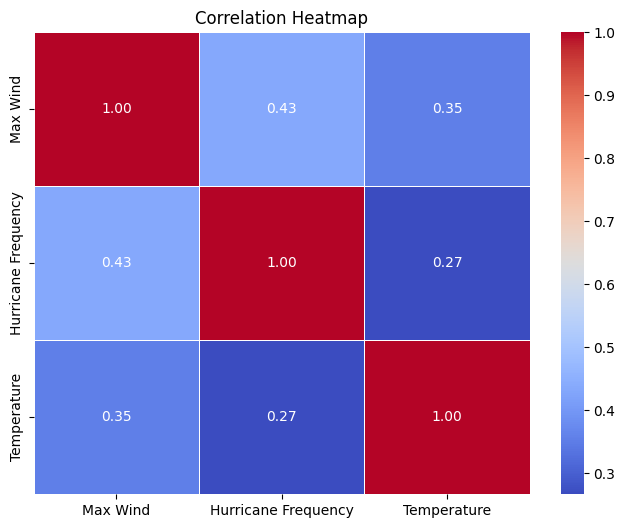

In [91]:
max_wind_per_year_df['Year'] = max_wind_per_year_df['Year'].astype(int)
hurricanes_per_year_df['Year'] = hurricanes_per_year_df['Year'].astype(int)
globalweatherdata['Year'] = globalweatherdata['Year'].astype(int)
max_wind_per_year_df_filtered = max_wind_per_year_df[(max_wind_per_year_df['Year'] >= 1999) & (max_wind_per_year_df['Year'] <= 2022)]
hurricanes_per_year_df_filtered = hurricanes_per_year_df[(hurricanes_per_year_df['Year'] >= 1999) & (hurricanes_per_year_df['Year'] <= 2022)]
globalweatherdata_filtered = globalweatherdata[(globalweatherdata['Year'] >= 1999) & (globalweatherdata['Year'] <= 2022)]

combined_data = pd.merge(max_wind_per_year_df_filtered, hurricanes_per_year_df_filtered, on='Year', suffixes=('_max_wind', '_hurricane'))
combined_data = pd.merge(combined_data, globalweatherdata_filtered, on='Year')

correlation_matrix = combined_data[['Max Wind', 'Hurricane Frequency', 'Temperature']].corr()

print("Correlation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

As based on the correlation matrix, we can see that there is a moderately positive correlation between Max Wind and Hurricane frequency (0.43), indicating that years with higher maximum sustained wind speeds tend to experience more frequent hurricanes. Additionally, there is also a moderately positive correlation between Max Wind and Temperature (0.35), implying that warmer years may coincide with higher maximum sustained wind speeds. The correlation between Hurricane Frequency and Temperature is relatively weak (0.27), which suggests that years with higher hurricane frequencies may have slightly higher temperatures than average.

# Conclusions

The analysis of the correlation matrix tells us about the dynamics between maximum wind speed, hurricane frequency, and temperature. We can see from the analysis that there is a moderate positive correlation between maximum sustained wind speed and hurricane frequency, which may mean that years with higher maximum wind speeds coincide with more frequent hurricanes. Additionally, there is a moderately positive correlation between maximum wind speed and temperature, suggesting that warmer years may experience higher maximum wind speeds. Despite this, the correlation between hurricane frequency and temperature is relatively weak. I do want to note however, that older storm data, may be more estimated, and advancements in measurement tools over time have improved the specificity of recording maximum wind values for storms. I especially noticed this with the values at the beginning of the dataset which were recorded in the mid-1800s. There could be a potential bias in the analysis due to varying data quality over time. Moreover, even though I used maximum wind speed in this assignment to evaluate storm intensity, it may not encompass all aspects of intensity (i.e. fatalities, hurricane costs). Thus, future analyses may benefit from considering additional factors to more comprehensively define and assess storm intensity.